# Ambiguous MRE Brain Segmentation 

## What is MR Brain Elastography and why image segmentation for MRE subjects? 



Magnetic Resonance Elastography (MRE) is a non-invasive MRI technique that measures the mechanical properties of brain tissue. During an MRE exam, gentle vibrations (usually between 50-200Hz) are applied externally to the patient’s head, generating tiny shear waves (5–20 μm in amplitude) that propagate through the brain. These sub-millimeter displacements are encoded in the MRI phase images and then processed to map tissue stiffness and viscosity. 

A shear wave is a type of mechanical wave in which particles of the medium move perpendicular to the direction of the wave travels. In MRE, the external vibrator (as shown in the image below), it induces transverse oscillations to the brain tissue. Because the wave's speed and wavelength depends on the tissue's stiffness and viscosity, measuring how these shear wave propagate let us calculate a map of mechanical properties without ever compressing or stretching the tissue along the wave's path.


<img src="/home/smooi/Desktop/toast/images/mre_equipment.png" 
     width="300px" 
     style="display:block; margin:20px auto;" />

As one of the highly senstive measure of brain structure and brain microstructal integrity, MRE uses wave mechanicals to determine to differences in brain tissue stiffness. It has been reported that mechanical properties can reflect aging, disease and cognitive function. The images below show the shear stiffness (first graph below) and damping ratio (second graph below) for the real and imaginary faces of the same complex shear modulus that MRE measures. 

<img src="/home/smooi/Desktop/toast/images/shear_stiffness.png" 
     width="300px" 
     style="display:block; margin:20px auto;" />

<img src="/home/smooi/Desktop/toast/images/damping_ratio.png" 
     width="300px" 
     title="Damping Ratio"
     style="display:block; margin:20px auto;" />

There are many skull-extraction tools (e.g. FSL BET), but they often fail on MRE data because of the following reasons. The major reason is due to the **long TE/T2 decay** in MRE that blurs boundaries. MRE spin-echo and EPI sequences use echo times (TE) often >= 40 ms to accomondate motion-encoding gradietns. At these TEs, transverse magnetization has decayed substantially, so the magnitude image SNR is lower and reduces the constrast between grey & white matters / brain & skull. BET's edge-detection replies on crisp intensity gradients, which get smeared out and lead to over- or -under masking at the cortex and base of skull. As shown in the picture below, the arrows shows that the FSL BET is not able to remove the noisy regions in the air canal (slice 15). 

<img src="/home/smooi/Desktop/toast/images/why_bet_dont_work.png" 
     width="300px" 
     style="display:block; margin:20px auto;" />


A clean and accurate boundary around the brain is crucial for non-linear inversion in MRE.

## What is probabilistic U-Net? What about PHiSeg? How are they different from a vanilla U-Net? 



The U-Net is a fully convolutional encoder–decoder architecture with symmetric skip connections between matching resolution levels.  
- **Encoder** downsamples the input through repeated conv + pooling, extracting hierarchical features.  
- **Decoder** upsamples via transposed convolutions, combining high-level context with low-level details via skip links.  
- **Output** is a single deterministic segmentation mask, optimized with a pixel-wise loss (e.g., Dice or cross-entropy).


However, the nature of the MRE images has high ambiguity. When different annotators approach the same subject, they may have different answers and produce different masks, where the quality of the mask will later be judged according to the stiffness map produced through non-linear inversion. In compared to the vanilla U-Net, probabilisitc U-Net (proposed by Kohl et al., 2018) augments the vanilla U-Net with a conditional variational autoencoder (cVAE) head to model segmentation ambiguity. During training, there is an extra posterior net that can learn from both the input t2stack image and the ground truth mask. A low-dimensional distribution over plausible segmentations is learned given the input image. At inference, different latent draw produce diverse segmentation hypotheses.

Something different that I have tweaked when adapting Kohl's probabilistic U-Net is fine-tuning with our dataset and also customize a simplier KL term to prevent posterior collapse. In order to demonstrate the impacts of adding those tweaks, we conducted multiple ablation studies below to add/remove elements to examine their impacts on preventing posterior collapse. 

Furthermore, a similar architecture, PHiSeg, further extends the probabilistic U-Net by introducing hierarchical latent variables at multiple decoder scales. This method is even more advanced that Kohl's method, which utilizes the characteristics of seeing an image at multiple resolutions and let the latent space to learn from different levels of an input image. The authors claimed that there will be better diversity in predictions.

Finally, to optimize the training time, I adopted the encoder and decoder structure from openAI's MONAI 3D U-Net. MONAI (Medical Open Network for Artifical Intelligence) is an open-source, PyTorch-based framework specifically designed for deep learning in healthcare imaging. They have really good optimization on memory, which greatly shortens our training time (even for heavier model like cVAE, it takes about 10 minutes to complete the training on 100+ subjects)! 

Disclaimer and Note for Future: 
- At the current stage of this project, I haven't taken a closer look about the optimization approach that MONAI uses. It will be very helpful to see how they used the mixed precision approach to reduce computation cost! It will be a worthful journey to understand how they optimize the usage of GPUs. 
- I am still working on building the PHiSeg so that results are not available yet. 
- Spoilers: Diversity in prediction is not obvious in prob U-Net, we'll need to finish the PHiSeg ASAP & get multiple annotators to improve the prediction diversity. 

## File Organization
[insert a github file structure framework here]

## Downloading the Data
The data is temporily unavailable to the public. Despite this, there are currently ~135 subjects with 1 annotation per subject, which are obtained on either GE or SIEMENS.  

## Data Preprocesing

The models requires the input to be uniform. We have a geometric and intensity standarization. Each volume is first resampled to a uniform physical voxel spacing (e.g., 1.5 x 1.5 x 1.5 mm). This ensures that the anatomical structures have a consistent size in terms of voxels, regardless of the original scanner's resolution. Them, we resized the matrix dimension to be (128 x 128 x 64 voxels) using the resize_volume function. After that, we have undergo an intensity normalization step where the intensity values of the T2 image are normalized using a z-score transformation. 

For better reproduction of the results, we split subject IDs into train.txt, val.txt, and test.txt files. This is a good practice that guarantees every experiment uses the exact same data splits, ensuring reproducibility. 

In addition, we also wrapped the preprocessed data in a class (MedicalDataset) that not only holds the image and label tensors. but also stores important metadata, such as the subject name and the original shape of the image before any resizing. We'll use this information to resize the predicted mask back to their original shape, before we continue with the further pipeline to send our t2stack to nli (in matlab). 

In [1]:
import torch
from utils.prepare_data import create_data_loaders

# Set up paths and params 
# train/test/val splits are fixed to the ratio of 70/15/15
t2_dir    = '/home/smooi/Desktop/toast/data/toast_pipe_data/t2stack'
mask_dir  = '/home/smooi/Desktop/toast/data/toast_pipe_data/mask'
train_txt = '/home/smooi/Desktop/toast/data/toast_pipe_data/train.txt'
val_txt   = '/home/smooi/Desktop/toast/data/toast_pipe_data/val.txt'
test_txt  = '/home/smooi/Desktop/toast/data/toast_pipe_data/test.txt'

batch_size  = 8
num_workers = 2
seed        = 42

# for reproducible shuffling
torch.manual_seed(seed)

# build loaders from fixed splits
data_loaders = create_data_loaders(
    mode='train',
    t2_dir=t2_dir,
    mask_dir=mask_dir,
    train_txt=train_txt,
    val_txt=val_txt,
    test_txt=test_txt,
    batch_size=batch_size,
    num_workers=num_workers
)

# Dataloaders below 
train_loader = data_loaders['train']
val_loader   = data_loaders['val']
test_loader  = data_loaders['test']

print(f"Train: {len(train_loader.dataset)}  |  "
      f"Val: {len(val_loader.dataset)}  |  "
      f"Test: {len(test_loader.dataset)}")


Found 135 T2 files
Found 0 NIfTI mask files
Found 135 MAT mask files
✓ Paired: G001_t2stack -> G001_mask.mat (mat)
✓ Paired: G002_t2stack -> G002_mask.mat (mat)
✓ Paired: G003_t2stack -> G003_mask.mat (mat)
✓ Paired: G004_t2stack -> G004_mask.mat (mat)
✓ Paired: G005_t2stack -> G005_mask.mat (mat)
✓ Paired: G006_t2stack -> G006_mask.mat (mat)
✓ Paired: G007_t2stack -> G007_mask.mat (mat)
✓ Paired: G008_t2stack -> G008_mask.mat (mat)
✓ Paired: G009_t2stack -> G009_mask.mat (mat)
✓ Paired: G010_t2stack -> G010_mask.mat (mat)
✓ Paired: G011_t2stack -> G011_mask.mat (mat)
✓ Paired: G012_t2stack -> G012_mask.mat (mat)
✓ Paired: G013_t2stack -> G013_mask.mat (mat)
✓ Paired: G014_t2stack -> G014_mask.mat (mat)
✓ Paired: G015_t2stack -> G015_mask.mat (mat)
✓ Paired: G016_t2stack -> G016_mask.mat (mat)
✓ Paired: G017_t2stack -> G017_mask.mat (mat)
✓ Paired: G018_t2stack -> G018_mask.mat (mat)
✓ Paired: G019_t2stack -> G019_mask.mat (mat)
✓ Paired: G020_t2stack -> G020_mask.mat (mat)
✓ Paired: G

## Experiments with Different Model Structures 

The purpose of this project is to generate diverse and reasonable predictions by taking a few "good guesses" rather than have a deterministic prediction. In order to access how well Prob U-Net and PHiSeg performed in terms of diverse predictions, we will run rigorous ablation studies against the determinisitc UNet and compare multiple metrics (shown in the table below) among techniques (particularly skills used for preventing posterior collapse)/models. Please note that all the evaluation will performed on the 15% hold-out test set. 

### Table of Metrics

| Metric              | Description                                                                                       |
|---------------------|---------------------------------------------------------------------------------------------------|
| **Mean DSC**        | The average Dice–Sørensen coefficient over all test volumes (± std), measuring overall segmentation accuracy. |
| **D²GED**           | The squared Generalized Energy Distance between the distribution of model samples and the expert annotation(s). Lower D²GED means the predicted distribution more closely matches ground truth variability. |
| **S_NCC**           | Spatial Normalized Cross-Correlation between sampled segmentations and expert mask(s). Higher S_NCC indicates stronger pixel-wise agreement in structure and boundaries. |
| **DSC_hard**        | Dice score computed **only** on the “hard” slices—i.e., the 10 % of axial slices where a deterministic U-Net achieved the lowest per-slice Dice. This focuses on the most challenging, ambiguous regions. Users can defined the percentage of slices that will be challenging for the model. In our model, we tracked per-slice Dice score after every epoch and keep track of the slices with the lowest 10% DSC. |
| **D²GED_hard**  | Diversity metric (e.g. pairwise sample distance or D²GED) restricted to those same “hard” slices. Quantifies how varied the multiple sampled masks are in the toughest areas. |


> **What are “hard” slices?**  
> During training, hard slices are monitored and labeled as the lowest 10% DSC after every epoch actively. 
> During inference, we rank every test slice by its per-slice Dice under a vanilla U-Net and designate the bottom 10 % as “hard.” All “hard” metrics (DSC_hard, Diversity_hard) are then computed over this subset to reveal performance where ambiguity is greatest. Please take note of the difference of how hard slices are defined for the training and inference stage. 

**reference**
For D²GED, please refer to Kohl et al., 2018 (https://arxiv.org/abs/1806.05034)
For S_NCC, please refer to Baumgartner et al., 2019 (https://arxiv.org/abs/1906.04045)

### Deterministic UNet 

In [ ]:
# Determinisitic UNet 
from train_prob_unet import train_prob_unet_slice_kl
from utils.model import ModelHome

model = ModelHome(
    image_channels=1,
    mask_channels=1,
    latent_dim=32,
    feature_channels=(32, 64, 128, 192), # arbitrary choice!
    num_res_units=2,
    seg_out_channels=1,
    inject_latent = False # 
)

# Train without KL so the loss matches the deterministic backbone
history = train_prob_unet_slice_kl(
    model, train_loader, val_loader,
    beta_final = 0.00, # no beta warmup for vanilla UNet 
    use_slice_kl=False, # no slice KL for vanilla UNet, so please IGNORE all the KL-related params below 
    worst_slice_percentage=0.1,     
    w_hard=0.4,                    
    w_other=1.0,                  
    dice_threshold=0.3,             
    num_epochs=100)

🚀 Training mode: Deterministic


[001] trDice=0.5399 | valDice=0.8198 | KL=0.000 | β=0.000 | actDims=00 | w̄=0.00 | KLvol=0.000 | hard%=0.00
   ✓ new best saved
[002] trDice=0.8468 | valDice=0.8716 | KL=0.000 | β=0.000 | actDims=00 | w̄=0.00 | KLvol=0.000 | hard%=0.00
   ✓ new best saved
[003] trDice=0.8982 | valDice=0.8854 | KL=0.000 | β=0.000 | actDims=00 | w̄=0.00 | KLvol=0.000 | hard%=0.00
   ✓ new best saved
[004] trDice=0.9268 | valDice=0.8856 | KL=0.000 | β=0.000 | actDims=00 | w̄=0.00 | KLvol=0.000 | hard%=0.00
   ✓ new best saved
[005] trDice=0.9375 | valDice=0.8911 | KL=0.000 | β=0.000 | actDims=00 | w̄=0.00 | KLvol=0.000 | hard%=0.00
   ✓ new best saved
[006] trDice=0.9430 | valDice=0.8868 | KL=0.000 | β=0.000 | actDims=00 | w̄=0.00 | KLvol=0.000 | hard%=0.00
[007] trDice=0.9438 | valDice=0.8977 | KL=0.000 | β=0.000 | actDims=00 | w̄=0.00 | KLvol=0.000 | hard%=0.00
   ✓ new best saved
[008] trDice=0.9444 | valDice=0.8876 | KL=0.000 | β=0.000 | actDims=00 | w̄=0.00 | KLvol=0.000 | hard%=0.00
[009] trDice=0.9

In [6]:
# Calculate the average DSC and Dice Hard for the UNet model
from utils.eval_metrics import dice_hard, dice_score_batch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# turn on eval mode 
model.eval()
all_logits = []
all_targets = []
with torch.no_grad():
    for batch in test_loader:
        imgs    = batch['image'].to(device)    # (B,1,H,W) or (B,1,D,H,W)
        masks   = batch['label'].to(device)
        logits  = model(imgs)                  # raw scores, same shape
        all_logits.append(logits)
        all_targets.append(masks)
# concatenate over all batches
all_logits = torch.cat(all_logits, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# now compute
dice_hard_val = dice_hard(all_logits, all_targets)            # uses sigmoid inside
dice_per_subj = dice_score_batch((all_logits.sigmoid()>0.5).float(), all_targets)
dice_avg = dice_per_subj.mean()

print(f"Dice Hard (10% worst slices): {dice_hard_val:.4f}")
print(f"Average DSC per subject: {dice_avg:.4f}")

Dice Hard (10% worst slices): 0.6055
Average DSC per subject: 0.9593


### Probabilistic U-Net

In [2]:
from utils.train_prob_unet import train_prob_unet_slice_kl
from utils.model import ModelHome
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_v1 = ModelHome(
    image_channels=1,
    mask_channels=1,
    latent_dim=32,
    feature_channels=(32, 64, 128, 192), # arbitrary choice!
    num_res_units=2,
    seg_out_channels=1,
    inject_latent = True # 
)


history = train_prob_unet_slice_kl(
    model_v1, train_loader, val_loader, device,
    use_slice_kl=True,
    beta_warmup=30,
    worst_slice_percentage=0.1,  # Analyze worst 10% of slices per subject
    w_hard=0.4,                  # Lower KL weight for hard cases
    w_other=1.0,                 # Normal KL weight
    # dice_threshold=0.5           # Dice threshold for "hard" slices
)

/home/smooi/miniconda3/envs/torch3090/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/smooi/miniconda3/envs/torch3090/lib/python3.9/site-packages/monai/networks/nets/unet.py:133: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


Probabilistic U-Net with latent vector injection enabled.PriorNet and PosteriorNet will be used.
Training mode: Probabilistic
KL Loss: Enabled
Slice-level KL: Enabled


/files/smooi/Desktop/toast/utils/train_prob_unet.py:62: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/files/smooi/Desktop/toast/utils/train_prob_unet.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[001] trDice=0.1903 | valDice=0.2011 | KL=1.499 | β=0.003 | actDims=31 | w̄=0.94 | KLvol=1.499 | hard%=0.00
 ✓ New best saved
[002] trDice=0.4234 | valDice=0.8475 | KL=0.520 | β=0.007 | actDims=31 | w̄=0.94 | KLvol=0.520 | hard%=0.00
 ✓ New best saved
[003] trDice=0.7968 | valDice=0.8922 | KL=0.689 | β=0.010 | actDims=32 | w̄=0.94 | KLvol=0.689 | hard%=0.00
 ✓ New best saved
[004] trDice=0.8450 | valDice=0.8839 | KL=1.425 | β=0.013 | actDims=32 | w̄=0.94 | KLvol=1.425 | hard%=0.00
[005] trDice=0.8992 | valDice=0.8880 | KL=1.979 | β=0.017 | actDims=32 | w̄=0.94 | KLvol=1.979 | hard%=0.00
[006] trDice=0.9162 | valDice=0.8890 | KL=1.002 | β=0.020 | actDims=32 | w̄=0.94 | KLvol=1.002 | hard%=0.00
[007] trDice=0.9085 | valDice=0.8913 | KL=1.013 | β=0.023 | actDims=32 | w̄=0.94 | KLvol=1.013 | hard%=0.00
[008] trDice=0.9380 | valDice=0.8901 | KL=0.606 | β=0.027 | actDims=32 | w̄=0.94 | KLvol=0.606 | hard%=0.00
[009] trDice=0.9413 | valDice=0.8904 | KL=0.548 | β=0.030 | actDims=32 | w̄=0.94 |


=== Per-subject metric summary ===
  Metric     Mean      Std   Median      Min      Max
     DSC 0.957969 0.017126 0.962926 0.909699 0.977597
     GED 0.081759 0.035429 0.069029 0.041135 0.180717
GED_HARD 0.509470 0.415415 0.313421 0.163168 1.933812
   S_NCC 0.947533 0.020724 0.953955 0.894017 0.972389


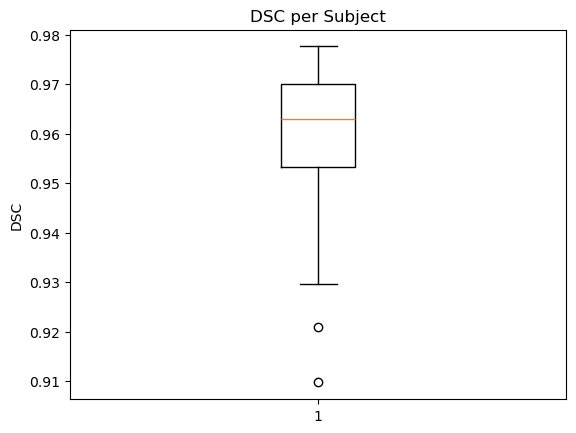

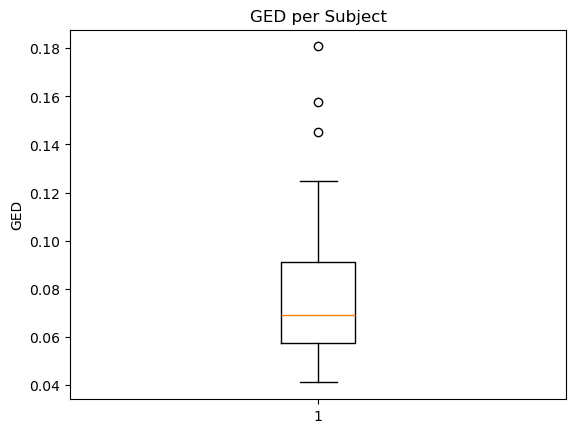

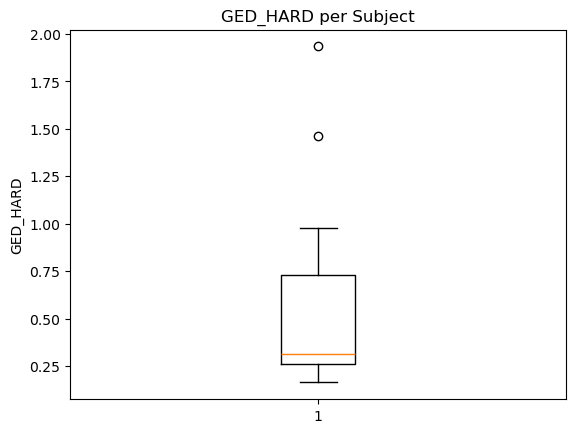

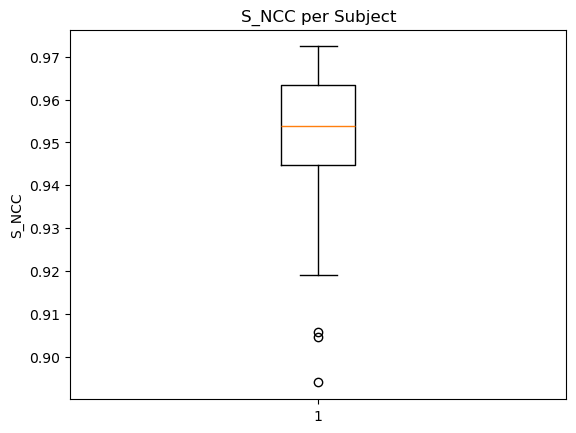


Dice-Hard (dataset, worst 10 % slices): 0.5570


In [36]:
"""
Evaluation / uncertainty benchmark for Prob-U-Net-style models
Assumes the following helpers live in utils.eval_metrics:

    dice_hard(all_logits, all_targets)
    dice_score_batch(pred_bin, targets)
    deg(samples, reference, distance_fn)
    deg_hard(samples, reference, distance_fn, hard_frac=0.1)
    s_ncc(pred, reference)

`test_loader` must return dicts with keys 'image' and 'label'.
"""

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# ------------------------------------------------------------------
#  Needed metrics
# ------------------------------------------------------------------
from utils.eval_metrics import (
    dice_hard,
    dice_score_batch,
    deg,
    deg_hard,        # <- GED on worst-Dice slices
    s_ncc
)

# ------------------------------------------------------------------
# Dice → distance helper for GED
# ------------------------------------------------------------------
def dice_distance(a: torch.Tensor, b: torch.Tensor, eps: float = 1e-7) -> torch.Tensor:
    """
    Dice distance = 1 – Dice score, shapes arbitrary & broadcastable.
    """
    a, b = a.float().view(-1), b.float().view(-1)
    inter = (a * b).sum()
    dice  = (2 * inter + eps) / (a.sum() + b.sum() + eps)
    return 1.0 - dice

# ------------------------------------------------------------------
# Evaluation
# ------------------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_v1.to(device).eval()

M            = 8       # MC samples / subject
HARD_FRAC    = 0.10    # worst-slice fraction for GED-Hard

# collect raw tensors for Dice (sigmoid logits) & per-subject stats
all_logits, all_targets = [], []
dice_list, ged_list, ged_hard_list, sncc_list = [], [], [], []

with torch.no_grad():
    for batch in test_loader:
        imgs   = batch['image'].to(device)   # (B,1,D,H,W) or (B,1,H,W)
        masks  = batch['label'].to(device)

        # deterministic forward pass for Dice
        logits = model_v1(imgs)
        all_logits.append(logits)
        all_targets.append(masks)

        # stochastic (dropout) predictions  -> binary samples
        mc_bin = torch.stack(
            [(model_v1(imgs).sigmoid() > 0.5).float() for _ in range(M)],
            dim=0                                     # (M,B,1,D,H,W or M,B,1,H,W)
        )

        B = masks.size(0)
        for b in range(B):
            ref     = masks[b]        # (1,D,H,W) or (1,H,W)
            samples = mc_bin[:, b]    # (M,1,D,H,W) or (M,1,H,W)

            ged_list.append(
                deg(samples, ref, dice_distance).item()
            )
            ged_hard_list.append(
                deg_hard(samples, ref, dice_distance, hard_frac=HARD_FRAC).item()
            )
            sncc_list.append(
                s_ncc(samples[0].squeeze(0), ref.squeeze(0)).item()
            )

# ------------------------------------------------------------------
# Dataset-level Dice metrics
# ------------------------------------------------------------------
all_logits  = torch.cat(all_logits,  dim=0)           # (N,1,D,H,W)
all_targets = torch.cat(all_targets, dim=0)

dice_per_subject = dice_score_batch(
    (all_logits.sigmoid() > 0.5).float(), all_targets
).cpu().numpy()

dice_hard_dataset = dice_hard(all_logits, all_targets).item()

# ------------------------------------------------------------------
# Build summary DataFrame
# ------------------------------------------------------------------
metric_arrays = {
    "DSC":       dice_per_subject,
    "GED":       np.array(ged_list),
    "GED_HARD":  np.array(ged_hard_list),
    "S_NCC":     np.array(sncc_list),
}

summary_rows = []
for name, arr in metric_arrays.items():
    summary_rows.append({
        "Metric":  name,
        "Mean":    arr.mean(),
        "Std":     arr.std(ddof=0),
        "Median":  np.median(arr),
        "Min":     arr.min(),
        "Max":     arr.max(),
    })

summary_df = pd.DataFrame(summary_rows)
print("\n=== Per-subject metric summary ===")
print(summary_df.to_string(index=False))

# ------------------------------------------------------------------
# Box-plots
# ------------------------------------------------------------------
for name, arr in metric_arrays.items():
    plt.figure()
    plt.boxplot(arr, vert=True)
    plt.title(f'{name} per Subject')
    plt.ylabel(name)
plt.show()

print(f"\nDice-Hard (dataset, worst {int(HARD_FRAC*100)} % slices): {dice_hard_dataset:.4f}")


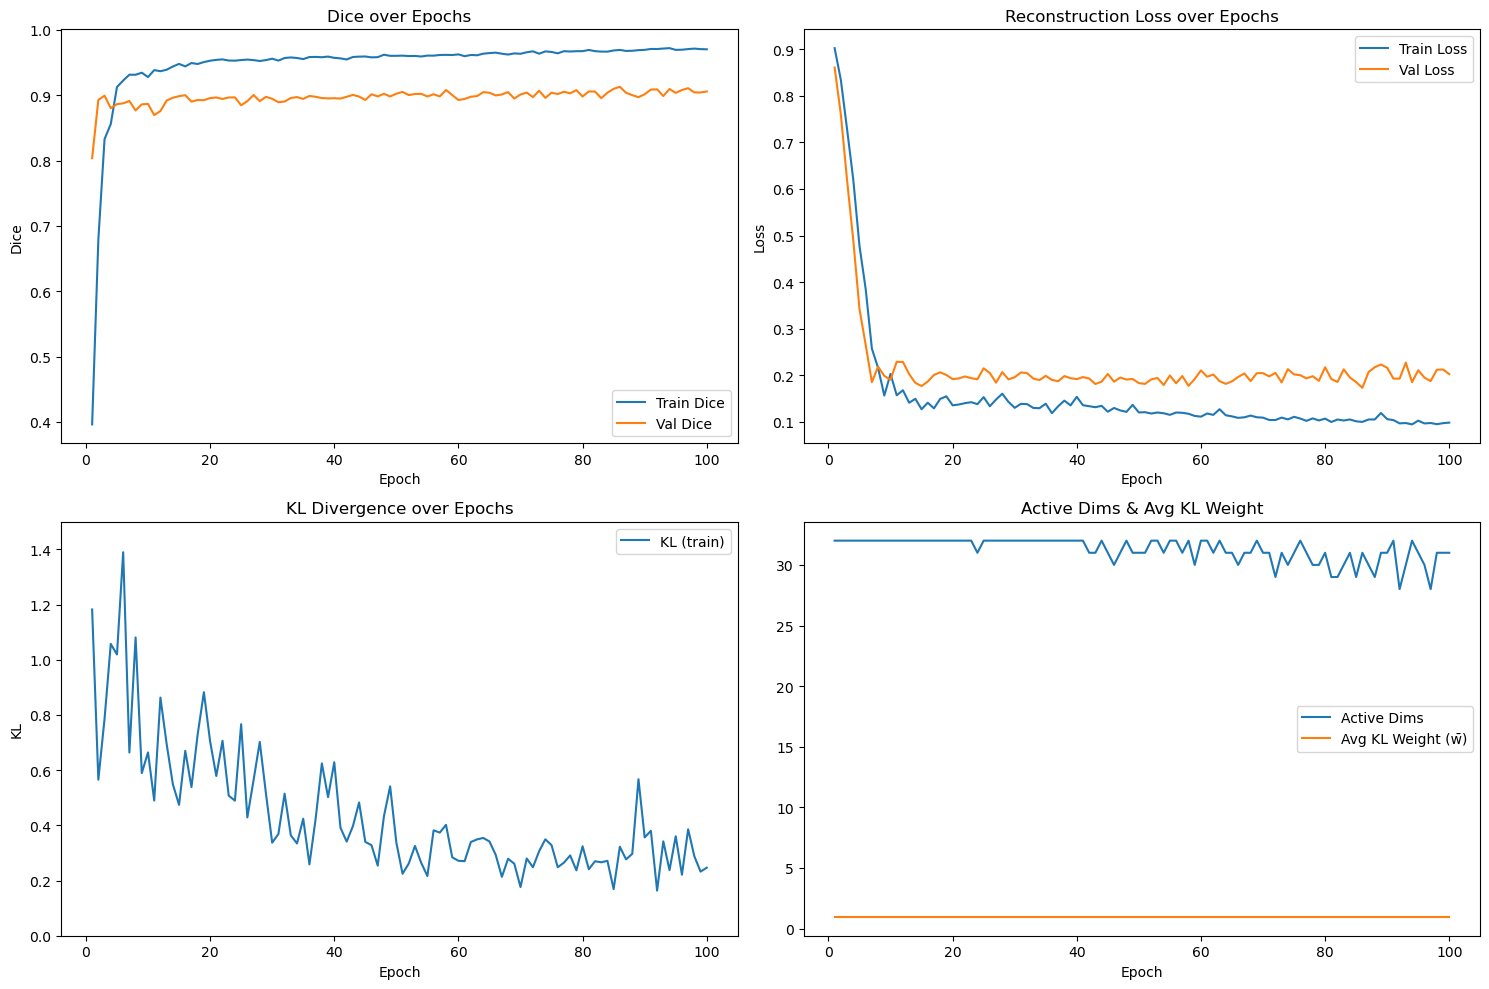

In [32]:
# Plot the training curve using the history above
import matplotlib.pyplot as plt

# assume `history` is the dict returned by train_prob_unet_slice_kl
epochs = list(range(1, len(history['train_dice']) + 1))

plt.figure(figsize=(15, 10))

# 1) Dice
plt.subplot(2, 2, 1)
plt.plot(epochs, history['train_dice'], label='Train Dice')
plt.plot(epochs, history['val_dice'],   label='Val Dice')
plt.xlabel('Epoch'); plt.ylabel('Dice')
plt.title('Dice over Epochs')
plt.legend()

# 2) Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'],   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Reconstruction Loss over Epochs')
plt.legend()

# 3) KL
if 'train_kl' in history:
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['train_kl'], label='KL (train)')
    plt.xlabel('Epoch'); plt.ylabel('KL')
    plt.title('KL Divergence over Epochs')
    plt.ylim(0, 1.5)   # <-- rescale y-axis from 0 to 2
    plt.legend()

# 4) Active dims & w̄
ax4 = plt.subplot(2, 2, 4)
if 'train_active_dims' in history:
    ax4.plot(epochs, history['train_active_dims'], label='Active Dims')
if 'train_w_bar' in history:
    ax4.plot(epochs, history['train_w_bar'], label='Avg KL Weight (w̄)')
ax4.set_xlabel('Epoch')
ax4.set_title('Active Dims & Avg KL Weight')
ax4.legend()

plt.tight_layout()
plt.show()


In [25]:
from utils.plot4uncertainty import *
import importlib, utils.plot4uncertainty as p4u
importlib.reload(p4u)

<module 'utils.plot4uncertainty' from '/files/smooi/Desktop/toast/utils/plot4uncertainty.py'>

In [ ]:
# Simple usage
from utils.plot4uncertainty import *

results = analyze_model_uncertainty(
    model=model_v1,
    loader=test_loader,  # Direct parameter name
    device='cuda',
    n_samples=8,
    n_visualize=6,
    n_worst_slices=12
)

# Access components
analyzer = results['analyzer']
visualizer = results['visualizer']
uncertainty_data = results['uncertainty_data']

In [27]:
from utils.train_prob_unet import train_prob_unet_slice_kl
from utils.model import ModelHome
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_v2 = ModelHome(
    image_channels=1,
    mask_channels=1,
    latent_dim=32,
    feature_channels=(32, 64, 128, 192), # arbitrary choice!
    num_res_units=2,
    seg_out_channels=1,
    inject_latent = True # 
)


history = train_prob_unet_slice_kl(
    model_v2, train_loader, val_loader, device,
    use_slice_kl=True,
    beta_warmup=30,
    worst_slice_percentage=0.1,  # Analyze worst 10% of slices per subject
    w_hard=0.6,                  # Lower KL weight for hard cases
    w_other=1.0,                 # Normal KL weight
    # dice_threshold=0.5           # Dice threshold for "hard" slices
)

Probabilistic U-Net with latent vector injection enabled.PriorNet and PosteriorNet will be used.
Training mode: Probabilistic
KL Loss: Enabled
Slice-level KL: Enabled


/home/smooi/miniconda3/envs/torch3090/lib/python3.9/site-packages/monai/networks/nets/unet.py:133: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")
/files/smooi/Desktop/toast/utils/train_prob_unet.py:62: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/files/smooi/Desktop/toast/utils/train_prob_unet.py:131: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[001] trDice=0.3962 | valDice=0.8038 | KL=1.182 | β=0.003 | actDims=32 | w̄=0.96 | KLvol=1.182 | hard%=0.00
 ✓ New best saved
[002] trDice=0.6788 | valDice=0.8930 | KL=0.565 | β=0.007 | actDims=32 | w̄=0.96 | KLvol=0.565 | hard%=0.00
 ✓ New best saved
[003] trDice=0.8330 | valDice=0.8994 | KL=0.786 | β=0.010 | actDims=32 | w̄=0.96 | KLvol=0.786 | hard%=0.00
 ✓ New best saved
[004] trDice=0.8559 | valDice=0.8803 | KL=1.058 | β=0.013 | actDims=32 | w̄=0.96 | KLvol=1.058 | hard%=0.00
[005] trDice=0.9127 | valDice=0.8864 | KL=1.019 | β=0.017 | actDims=32 | w̄=0.96 | KLvol=1.019 | hard%=0.00
[006] trDice=0.9226 | valDice=0.8877 | KL=1.390 | β=0.020 | actDims=32 | w̄=0.96 | KLvol=1.390 | hard%=0.00
[007] trDice=0.9315 | valDice=0.8913 | KL=0.664 | β=0.023 | actDims=32 | w̄=0.96 | KLvol=0.664 | hard%=0.00
[008] trDice=0.9314 | valDice=0.8768 | KL=1.081 | β=0.027 | actDims=32 | w̄=0.96 | KLvol=1.081 | hard%=0.00
[009] trDice=0.9346 | valDice=0.8861 | KL=0.589 | β=0.030 | actDims=32 | w̄=0.96 |


=== Per-subject metric summary ===
  Metric     Mean      Std   Median      Min      Max
     DSC 0.957663 0.021481 0.962680 0.878338 0.977083
     GED 0.078515 0.039658 0.070334 0.043272 0.221183
GED_HARD 0.481155 0.365717 0.347928 0.153049 1.701195
   S_NCC 0.947066 0.026301 0.951800 0.842471 0.969914


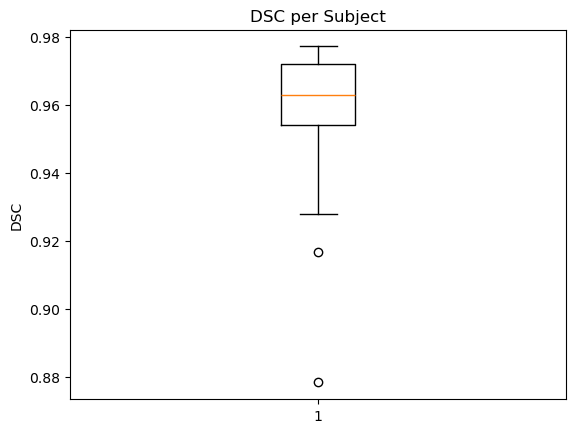

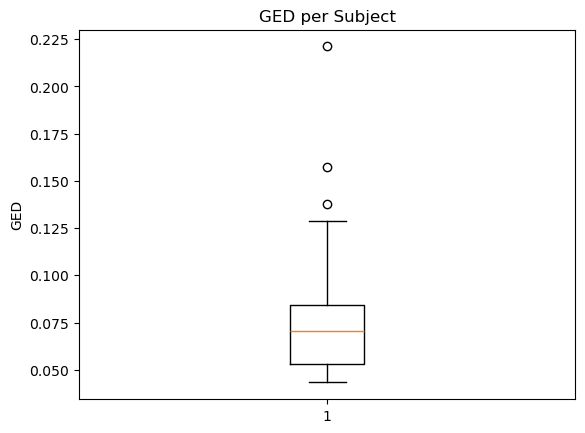

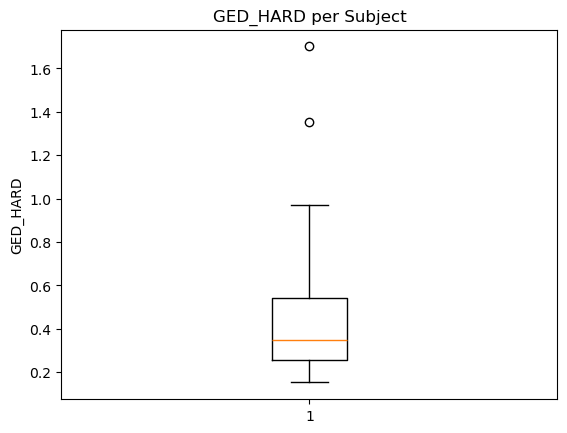

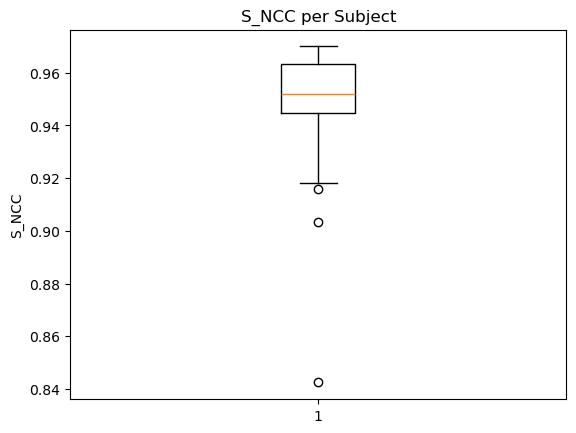


Dice-Hard (dataset, worst 10 % slices): 0.5645


In [ ]:
"""
Evaluation / uncertainty benchmark for Prob-U-Net-style models
Assumes the following helpers live in utils.eval_metrics:

    dice_hard(all_logits, all_targets)
    dice_score_batch(pred_bin, targets)
    deg(samples, reference, distance_fn)
    deg_hard(samples, reference, distance_fn, hard_frac=0.1)
    s_ncc(pred, reference)

`test_loader` must return dicts with keys 'image' and 'label'.
"""

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# ------------------------------------------------------------------
#  Needed metrics
# ------------------------------------------------------------------
from utils.eval_metrics import (
    dice_hard,
    dice_score_batch,
    deg,
    deg_hard,        # <- GED on worst-Dice slices
    s_ncc
)

# ------------------------------------------------------------------
# Dice → distance helper for GED
# ------------------------------------------------------------------
def dice_distance(a: torch.Tensor, b: torch.Tensor, eps: float = 1e-7) -> torch.Tensor:
    """
    Dice distance = 1 – Dice score, shapes arbitrary & broadcastable.
    """
    a, b = a.float().view(-1), b.float().view(-1)
    inter = (a * b).sum()
    dice  = (2 * inter + eps) / (a.sum() + b.sum() + eps)
    return 1.0 - dice

# ------------------------------------------------------------------
# Evaluation
# ------------------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_v2.to(device).eval()

M            = 8       # MC samples / subject
HARD_FRAC    = 0.10    # worst-slice fraction for GED-Hard

# collect raw tensors for Dice (sigmoid logits) & per-subject stats
all_logits, all_targets = [], []
dice_list, ged_list, ged_hard_list, sncc_list = [], [], [], []

with torch.no_grad():
    for batch in test_loader:
        imgs   = batch['image'].to(device)   # (B,1,D,H,W) or (B,1,H,W)
        masks  = batch['label'].to(device)

        # deterministic forward pass for Dice
        logits = model_v2(imgs)
        all_logits.append(logits)
        all_targets.append(masks)

        # stochastic (dropout) predictions  -> binary samples
        mc_bin = torch.stack(
            [(model_v2(imgs).sigmoid() > 0.5).float() for _ in range(M)],
            dim=0                                     # (M,B,1,D,H,W or M,B,1,H,W)
        )

        B = masks.size(0)
        for b in range(B):
            ref     = masks[b]        # (1,D,H,W) or (1,H,W)
            samples = mc_bin[:, b]    # (M,1,D,H,W) or (M,1,H,W)

            ged_list.append(
                deg(samples, ref, dice_distance).item()
            )
            ged_hard_list.append(
                deg_hard(samples, ref, dice_distance, hard_frac=HARD_FRAC).item()
            )
            sncc_list.append(
                s_ncc(samples[0].squeeze(0), ref.squeeze(0)).item()
            )

# ------------------------------------------------------------------
# Dataset-level Dice metrics
# ------------------------------------------------------------------
all_logits  = torch.cat(all_logits,  dim=0)           # (N,1,D,H,W)
all_targets = torch.cat(all_targets, dim=0)

dice_per_subject = dice_score_batch(
    (all_logits.sigmoid() > 0.5).float(), all_targets
).cpu().numpy()

dice_hard_dataset = dice_hard(all_logits, all_targets).item()

# ------------------------------------------------------------------
# Build summary DataFrame
# ------------------------------------------------------------------
metric_arrays = {
    "DSC":       dice_per_subject,
    "GED":       np.array(ged_list),
    "GED_HARD":  np.array(ged_hard_list),
    "S_NCC":     np.array(sncc_list),
}

summary_rows = []
for name, arr in metric_arrays.items():
    summary_rows.append({
        "Metric":  name,
        "Mean":    arr.mean(),
        "Std":     arr.std(ddof=0),
        "Median":  np.median(arr),
        "Min":     arr.min(),
        "Max":     arr.max(),
    })

summary_df = pd.DataFrame(summary_rows)
print("\n=== Per-subject metric summary ===")
print(summary_df.to_string(index=False))

# ------------------------------------------------------------------
# Box-plots
# ------------------------------------------------------------------
for name, arr in metric_arrays.items():
    plt.figure()
    plt.boxplot(arr, vert=True)
    plt.title(f'{name} per Subject')
    plt.ylabel(name)
plt.show()

print(f"\nDice-Hard (dataset, worst {int(HARD_FRAC*100)} % slices): {dice_hard_dataset:.4f}")


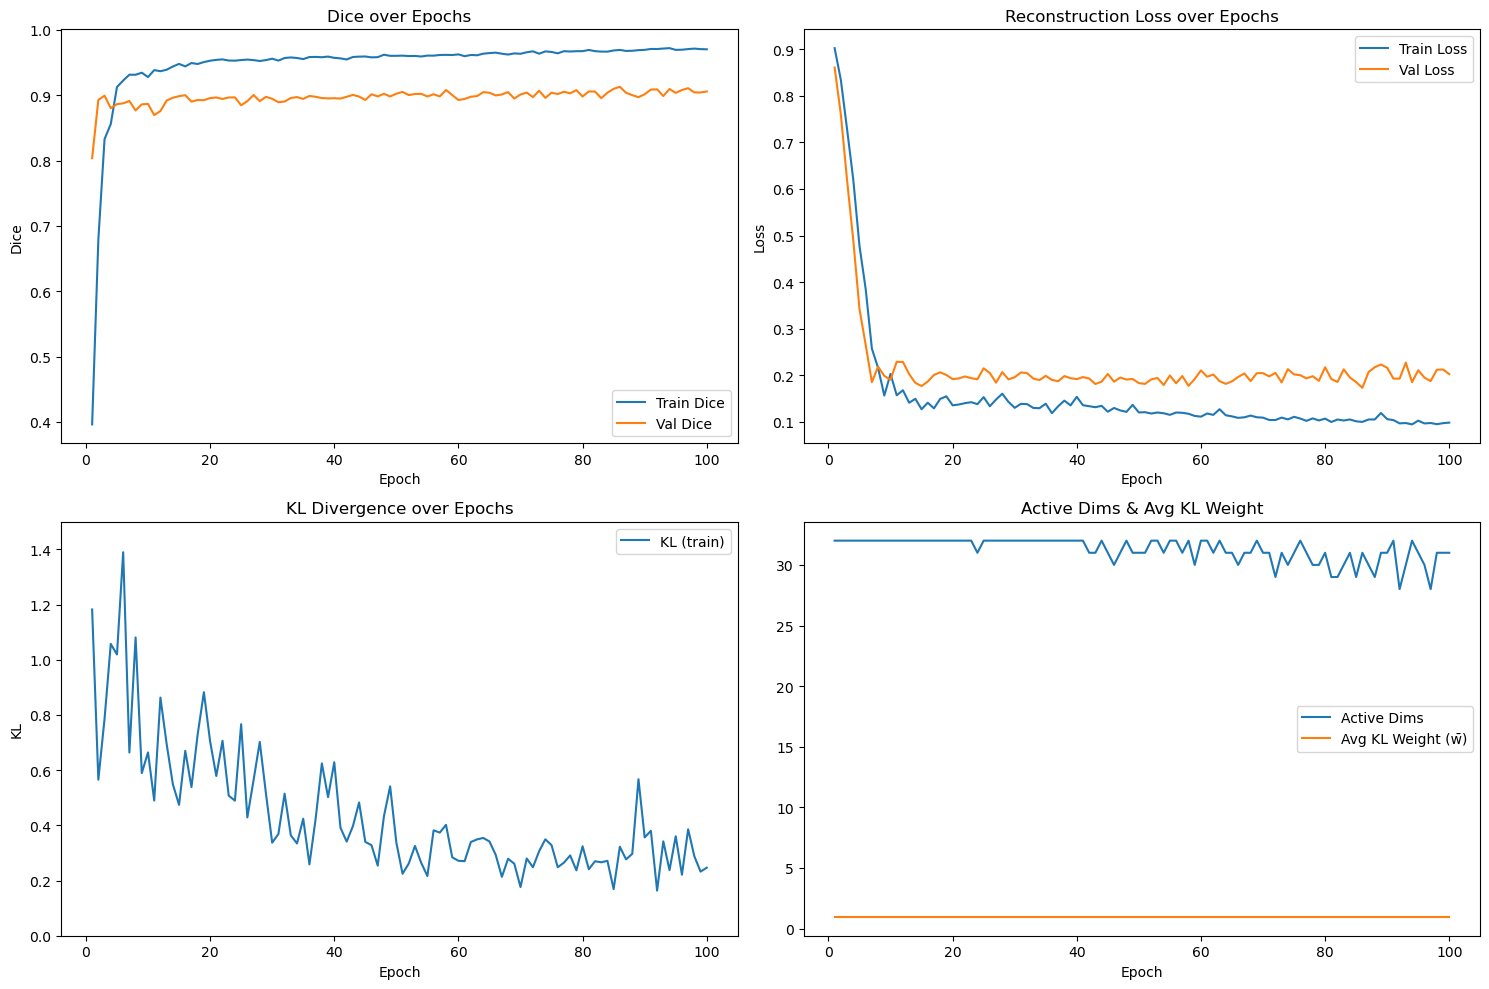

In [33]:
# Plot the training curve using the history above
import matplotlib.pyplot as plt

# assume `history` is the dict returned by train_prob_unet_slice_kl
epochs = list(range(1, len(history['train_dice']) + 1))

plt.figure(figsize=(15, 10))

# 1) Dice
plt.subplot(2, 2, 1)
plt.plot(epochs, history['train_dice'], label='Train Dice')
plt.plot(epochs, history['val_dice'],   label='Val Dice')
plt.xlabel('Epoch'); plt.ylabel('Dice')
plt.title('Dice over Epochs')
plt.legend()

# 2) Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'],   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Reconstruction Loss over Epochs')
plt.legend()

# 3) KL
if 'train_kl' in history:
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['train_kl'], label='KL (train)')
    plt.xlabel('Epoch'); plt.ylabel('KL')
    plt.title('KL Divergence over Epochs')
    plt.ylim(0, 1.5)   # <-- rescale y-axis from 0 to 2
    plt.legend()

# 4) Active dims & w̄
ax4 = plt.subplot(2, 2, 4)
if 'train_active_dims' in history:
    ax4.plot(epochs, history['train_active_dims'], label='Active Dims')
if 'train_w_bar' in history:
    ax4.plot(epochs, history['train_w_bar'], label='Avg KL Weight (w̄)')
ax4.set_xlabel('Epoch')
ax4.set_title('Active Dims & Avg KL Weight')
ax4.legend()

plt.tight_layout()
plt.show()
